## Repo Analysis

In [2]:
%load_ext autoreload
%autoreload 2

In [5]:
from utils.git_utils import clone_repo
from pathlib import Path
from analyzers.repo_analyzer import RepoAnalyzer, NodeKind, is_kind, EdgeType
from verifiers.hw1 import APEHW1

pv = APEHW1('./tmp/Project_CodeNet/Project_CodeNet_C++1400/p00000/s229748691.cpp')
analyzer = RepoAnalyzer.from_path('./tmp/Project_CodeNet/Project_CodeNet_C++1400/p00000/s229748691.cpp', pv)
PROJECT_DIR = analyzer.repo_path

NotADirectoryError: [Errno 20] Not a directory: '/home/ayuram/pesquared/tmp/Project_CodeNet/Project_CodeNet_C++1400/p00000/s229748691.cpp/__uber.cpp'

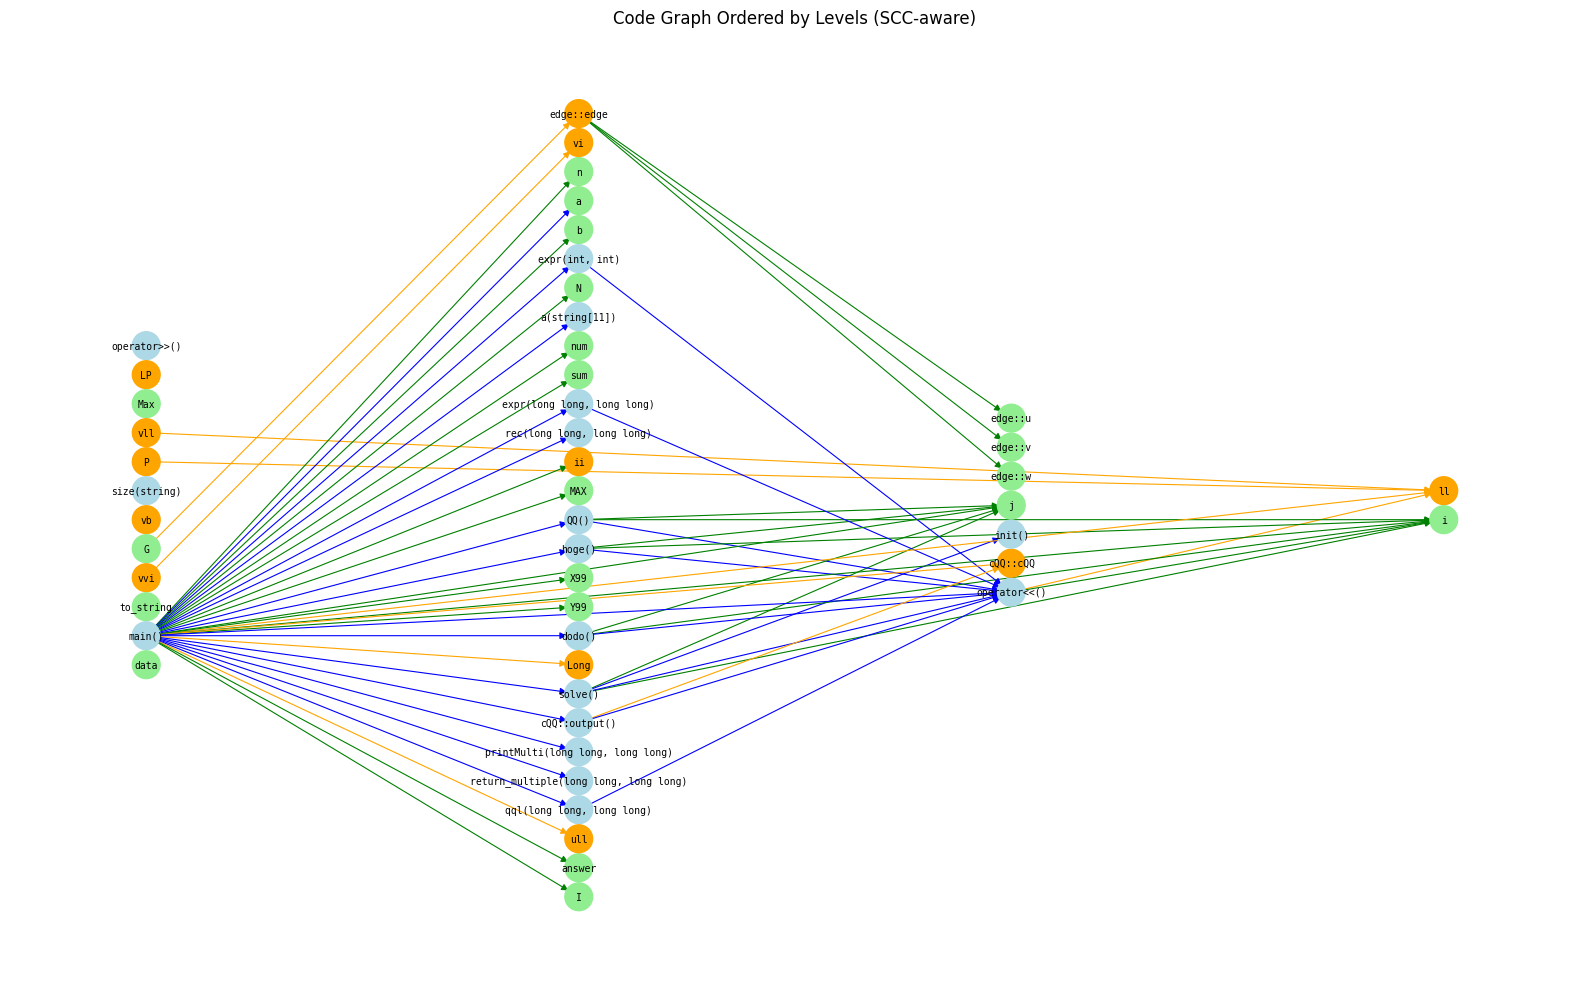

In [4]:
analyzer.plot(horizontal=True, node_filter=lambda node, attrs: (len(list(analyzer.predecessors(node))) != 0 or node == 'main()') 
              and is_kind(attrs["kind"], NodeKind.IN_CODEBASE))
# neural training law

In [ ]:
for node in analyzer.nodes():
    if is_kind(analyzer.nodes[node]["kind"], NodeKind.FUNCTION):
        if 'missed_optimizations' in analyzer.nodes[node]:
            print(node)
            missed = analyzer.nodes[node]['missed_optimizations']
            for i in range(len(missed)):
                if i in missed:
                    print(f"  {i}. {missed[i]}")
            print("======================")

In [ ]:
%load_ext autoreload
%autoreload all

In [ ]:
from analyzers.control_flow import ControlFlowGraph
node = 'Sphere::getNormal(Vector)'
cfg = ControlFlowGraph(analyzer.nodes[node]['cursor'], file=analyzer.get_file(analyzer.nodes[node]['file']))
# print(cfg.cognitive_complexity())
# print(cfg.cyclomatic_complexity())
print(analyzer.nodes[node]['code'])
cfg.plot_dag_horizontal_level()

In [ ]:
from analyzers.data_flow import DataFlowGraph
node = 'Sphere::getNormal(Vector)'
cfg = DataFlowGraph(analyzer.nodes[node]['cursor'], file=analyzer.get_file(analyzer.nodes[node]['file']))
# print(cfg.cognitive_complexity())
# print(cfg.cyclomatic_complexity())
print(analyzer.nodes[node]['code'])
cfg.plot()

In [3]:
from analyzers.function_slicer import FunctionSlicer
node = 'calcColor(unsigned char *, Autonoma *, Ray, unsigned int)'
file = analyzer.get_file(analyzer.nodes[node]['file'])
# print(analyzer.nodes[node]['ast'])
slicer = FunctionSlicer(analyzer.nodes[node]['cursor'], file)
sliced_code = slicer.whole_slice_snippet(67, 1, collapse_threshold=5)

print(sliced_code)

void calcColor(unsigned char* toFill,Autonoma* c, Ray ray, unsigned int depth){
   TimeAndShape *times = (TimeAndShape*)malloc(0);
   size_t seen = 0;
   while(t!=NULL){
      TimeAndShape *times2 = (TimeAndShape*)malloc(sizeof(TimeAndShape)*(seen + 1));
         times2[i] = times[i];
      times2[seen] = (TimeAndShape){ time, t->data };
      free(times);
      times = times2;
   }
   insertionSort(times, seen);
   if (seen == 0 || times[0].time == inf) {
   // …
   }
   double curTime = times[0].time;
   Shape* curShape = times[0].shape;
   free(times);
   // …
}


In [ ]:
from analyzers.stack_analyzer import StackAnalyzer, FunctionStats

stack_analyzer = StackAnalyzer(f'{PROJECT_DIR}/perfstacks')
stats = stack_analyzer.get_top_functions(7)
for stat in stats:
    corresponding_signatures = analyzer.symbol_to_signatures.get(stat.name, [])
    if len(corresponding_signatures) == 1:
        print(f"Function: {stat.name}, Signature: {corresponding_signatures[0]}, Calls: {stat.exclusive_time}, Chain: {stat.call_chain}")
    elif len(corresponding_signatures) > 1:
        print(f"Warning - multiple signatures found for function: {stat.name}")
        print(f"Function: {stat.name}, Signatures: {', '.join(corresponding_signatures)}, Calls: {stat.exclusive_time}")

## Obfuscation

In [13]:
from obfuscators.code_obfuscator import CodeObfuscator
import random
import textwrap
from utils.string_utils import remove_comments

# function_nodes = [node for node, attrs in analyzer.nodes(data=True) if is_kind(attrs["kind"], NodeKind.FUNCTION) and is_kind(attrs["kind"], NodeKind.IN_CODEBASE)]
# random_node = random.choice(list(function_nodes))
# successors = list(analyzer.successors(random_node))
# nodes = [analyzer.nodes[n] for n in successors]
# nodes.append(analyzer.nodes[random_node])

obfuscator = CodeObfuscator(tier=2, nodes=[analyzer.nodes[node]], project_root=PROJECT_DIR)

code = analyzer.nodes[node]['code']

obfuscated_code = obfuscator.obfuscate(code)
deobfuscated_code = obfuscator.deobfuscate(obfuscated_code)

print("\nOriginal code:")
print(textwrap.indent(code, "  "))

print("\nObfuscated code:")
print(textwrap.indent(obfuscated_code, "  "))

print("\nObfuscation map:")
for orig, obf in obfuscator.obfuscation_map.items():
    print(f"  {orig} -> {obf}")

if remove_comments(deobfuscated_code) == remove_comments(code):
    print("\n✅ Deobfuscation successful!")
else:
    print("\n❌ Deobfuscation failed.")
    # print the deobfuscated code
    print(textwrap.indent(deobfuscated_code, "  "))
    


Original code:
  void calcColor(unsigned char* toFill,Autonoma* c, Ray ray, unsigned int depth){
     ShapeNode* t = c->listStart;
     TimeAndShape *times = (TimeAndShape*)malloc(0);
     size_t seen = 0;
     while(t!=NULL){
        double time = t->data->getIntersection(ray);

        TimeAndShape *times2 = (TimeAndShape*)malloc(sizeof(TimeAndShape)*(seen + 1));
        for (int i=0; i<seen; i++)
           times2[i] = times[i];
        times2[seen] = (TimeAndShape){ time, t->data };
        free(times);
        times = times2;
        seen ++;
        t = t->next;
     }
     insertionSort(times, seen);
     if (seen == 0 || times[0].time == inf) {
        double opacity, reflection, ambient;
        Vector temp = ray.vector.normalize();
        const double x = temp.x;
        const double z = temp.z;
        const double me = (temp.y<0)?-temp.y:temp.y;
        const double angle = atan2(z, x);
        c->skybox->getColor(toFill, &ambient, &opacity, &reflection, fix(angle/M_TWO_P

## Optimization

In [ ]:
from optimizers.repo_optimizer import RepoOptimizer

optimizer = RepoOptimizer('gemini-1.5-flash', 'google', analyzer)
optimizer.optimize_repo()